# Cinema LSTM

----

Starting from Panda and Numpy

In [1]:
# pandas as pd
try:
    import pandas as pd
    print('Pandas already installed, only imported')
except:
    !pip install pandas
    import pandas as pd
    print('Pandas was not installed, installed and imported')
    
# numpy as np
try:
    import numpy as np
    print('NumPy already installed, only imported')
except:
    !pip install numpy
    import numpy as np
    print('NumPy was not installed, installed and imported')
    
# pyplot as plt
try:
    import matplotlib.pyplot as plt
    print('PyPlot already installed, only imported')
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    print('PyPlot was not installed, installed and imported')    


import tensorflow as tf


Pandas already installed, only imported
NumPy already installed, only imported
PyPlot already installed, only imported


In [2]:
cinema = pd.read_csv('../data/cinema.csv', sep=';', low_memory=False)

# Mapping dictionary for translating Dutch day names to English
dutch_to_english = {
    'Zondag': 'Sunday',
    'maandag': 'Monday',
    'dinsdag': 'Tuesday',
    'woensdag': 'Wednesday',
    'donderdag': 'Thursday',
    'vrijdag': 'Friday',
    'zaterdag': 'Saturday'
}

# Translate Dutch day names to English
cinema['Day'] = cinema['Day'].map(dutch_to_english)

# Convert the "Date" column to datetime
cinema['Date'] = pd.to_datetime(cinema['Date'], format='%d/%m/%Y')

# Drop rows with missing values in the "Visitor" column
cinema = cinema.dropna(subset=['Visitor'])

# Convert the "Visitor" column to numeric to check for non-numeric values
cinema['Visitor'] = pd.to_numeric(cinema['Visitor'], errors='coerce')

# Drop rows with non-numeric values in the "Visitor" column
cinema = cinema.dropna(subset=['Visitor'])

# Convert the "Visitor" column to integer
cinema['Visitor'] = cinema['Visitor'].astype(int)

# Extract each column into separate variables
day_categorical = cinema['Day'].astype('category')
date = cinema['Date']
visitor = cinema['Visitor']

In [3]:
cinema.head()

,Day,Date,Visitor
0,Sunday,2023-01-01,484
1,Monday,2023-01-02,832
2,Tuesday,2023-01-03,872
3,Wednesday,2023-01-04,1003
4,Thursday,2023-01-05,851


In [4]:
cinema.dtypes

Day                object
Date       datetime64[ns]
Visitor             int32
dtype: object

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

# Summary statistics for visitor counts
visitor_summary = cinema['Visitor'].describe()

# Print the summary statistics
print(visitor_summary)

count     428.000000
mean      497.616822
std       269.279597
min       107.000000
25%       304.500000
50%       406.500000
75%       653.750000
max      1437.000000
Name: Visitor, dtype: float64


In [6]:
cinema.head()

,Day,Date,Visitor
0,Sunday,2023-01-01,484
1,Monday,2023-01-02,832
2,Tuesday,2023-01-03,872
3,Wednesday,2023-01-04,1003
4,Thursday,2023-01-05,851


Tune Hyperparameters

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Function to create LSTM model
def create_lstm_model(neurons=50, activation='tanh', optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(neurons, activation=activation))
    model.add(Dense(1))
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(cinema['Visitor'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model as a KerasRegressor
model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'neurons': [50, 100],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.01],
    'epochs': [50, 100]  # Adjust the number of epochs as needed
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

# Print best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Get the best model
best_model = grid_result.best_estimator_

# Train the best model
best_model.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'], batch_size=32, verbose=0)

# Evaluate the best model
loss = best_model.score(X_test, y_test)
print(f"LSTM Model Test Loss: {loss}")

C:\Users\mario\AppData\Local\Temp\ipykernel_150204\1622493345.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=adam; total time=   1.9s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=adam; total time=   1.6s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=adam; total time=   1.6s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=rmsprop; total time=   1.5s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=rmsprop; total time=   1.8s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=rmsprop; total time=   1.5s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=100, optimizer=adam; total time=   2.3s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=100, optimizer=adam; total time=   2.3s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=100, optimizer=adam; t

LSTM Model Test Loss: 0.03617819398641586
3/3 [==============================] - 0s 2ms/step


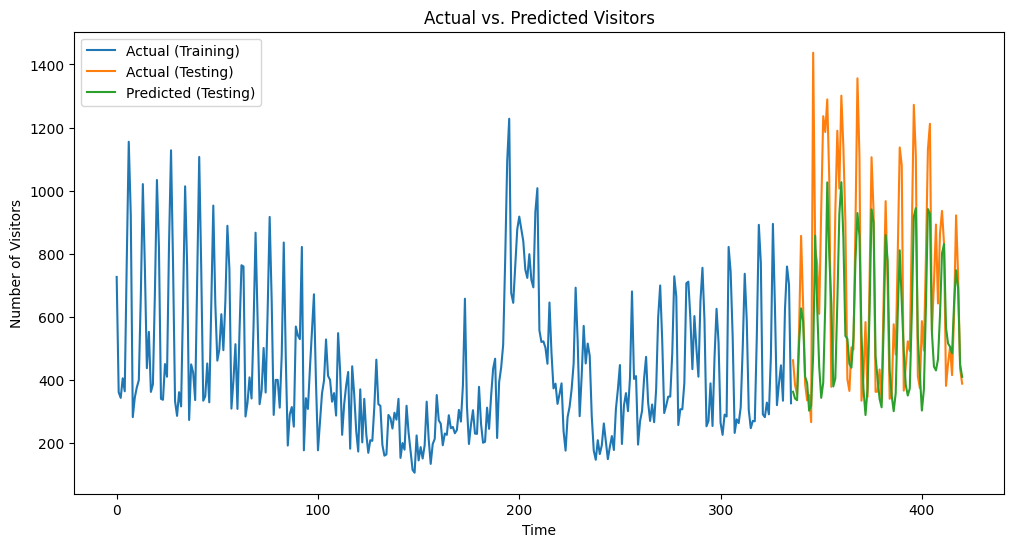

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(cinema['Visitor'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(1))

# Define optimizer with learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse')

# Train the model with specified epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)

# Inverse scale the actual values for plotting
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted visitor numbers
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')
plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')
plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()

In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the baseline prediction using the average of actual values
baseline_prediction = np.mean(actual_values)
baseline_predictions = np.full_like(actual_values, baseline_prediction)

# Evaluate the baseline model using Mean Squared Error (MSE)
baseline_mse = mean_squared_error(actual_values, baseline_predictions)
print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")

# Calculate Root Mean Squared Error (RMSE) for the baseline model
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE) for the baseline model
baseline_mape = np.mean(np.abs((actual_values - baseline_predictions) / actual_values)) * 100
print(f"Baseline Mean Absolute Percentage Error (MAPE): {baseline_mape}%")

# Calculate R-squared (coefficient of determination) for the baseline model
baseline_r2 = r2_score(actual_values, predictions)
print(f"Baseline R-squared (Coefficient of Determination): {baseline_r2}")


Baseline Mean Squared Error (MSE): 19311.742857142857
Baseline Root Mean Squared Error (RMSE): 138.96669693542714
Minimum value: 59
Maximum value: 443
Range: 384
Baseline Mean Absolute Percentage Error (MAPE): 100.49106537715384%
Baseline R-squared (Coefficient of Determination): 0.9121436277319293


In [10]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 63995.605810316716
Root Mean Squared Error (RMSE): 252.97352788447395
Minimum value: 267.0
Maximum value: 1437.0
Range: 1170.0
Mean Absolute Percentage Error (MAPE): 23.561753965470135%
R-squared (Coefficient of Determination): 0.34988570675650743


In [11]:
#Serialize Model
#model.save("cinemadata_model.h5")

#Serialize scaler
import pickle

with open('scaler_cinema.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [7]:
# Wi-fi LSTM

Import the data:

In [8]:
wifi_data = pd.read_csv("../data/wifi_data.csv", low_memory=False)

In [9]:
wifi_data.head()

,Date Time,Date Time(RAW),Total Online Devices,Total Online Devices(RAW),Speed Bad,Speed Bad(RAW),Speed Good,Speed Good(RAW),Speed Better,Speed Better(RAW),...,Experience Bad,Experience Bad(RAW),Experience Good,Experience Good(RAW),Experience Better,Experience Better(RAW),Downtime,Downtime(RAW),Coverage,Coverage(RAW)
0,1-9-2023 00:00:00 - 01:00:00,45169.95833,61 #,60.9000,"0,57 #",0.5667,"9,88 #",9.8833,50 #,50.4500,...,"0,62 #",0.6167,"0,17 #",0.1667,62 #,62.3667,0%,0.0,100%,10000.0
1,1-9-2023 01:00:00 - 02:00:00,45170.00000,58 #,58.3500,"0,85 #",0.8500,11 #,10.7833,47 #,46.7167,...,"0,55 #",0.5500,"0,15 #",0.1500,58 #,58.4500,0%,0.0,100%,10000.0
2,1-9-2023 02:00:00 - 03:00:00,45170.04167,57 #,57.3833,"0,47 #",0.4667,"9,73 #",9.7333,47 #,47.1833,...,"0,38 #",0.3833,"0,17 #",0.1667,57 #,56.8333,0%,0.0,100%,10000.0
3,1-9-2023 03:00:00 - 04:00:00,45170.08333,57 #,57.4000,"0,52 #",0.5167,10 #,10.4000,46 #,46.4833,...,"0,15 #",0.1500,0 #,0.0000,57 #,57.3667,0%,0.0,100%,10000.0
4,1-9-2023 04:00:00 - 05:00:00,45170.12500,57 #,57.1333,"0,30 #",0.3000,10 #,10.4833,46 #,46.3500,...,"0,42 #",0.4167,"0,17 #",0.1667,57 #,56.9667,0%,0.0,100%,10000.0


Use only the necessary columns from our dataset:

In [10]:
wifi_data = wifi_data[['Date Time', 'Total Online Devices']]
wifi_data.head()

,Date Time,Total Online Devices
0,1-9-2023 00:00:00 - 01:00:00,61 #
1,1-9-2023 01:00:00 - 02:00:00,58 #
2,1-9-2023 02:00:00 - 03:00:00,57 #
3,1-9-2023 03:00:00 - 04:00:00,57 #
4,1-9-2023 04:00:00 - 05:00:00,57 #


Ok, now let's check if there's any missing values

In [11]:
wifi_data.isnull().sum()

Date Time                0
Total Online Devices    52
dtype: int64

Drop the null values from the dataset:

In [12]:
wifi_data = wifi_data.dropna()
wifi_data.isna().sum()

Date Time               0
Total Online Devices    0
dtype: int64

Convert the value of the total number of the devices to an integer:

In [13]:
wifi_data['Total Online Devices'] = wifi_data['Total Online Devices'].str.replace('#','').astype(int)

Have a look of the chnaged data and check their data type:

In [14]:
wifi_data.head()

,Date Time,Total Online Devices
0,1-9-2023 00:00:00 - 01:00:00,61
1,1-9-2023 01:00:00 - 02:00:00,58
2,1-9-2023 02:00:00 - 03:00:00,57
3,1-9-2023 03:00:00 - 04:00:00,57
4,1-9-2023 04:00:00 - 05:00:00,57


Group all the all data based on the date. Add the total, mean, max and min of the devices conneted on a specific date:

In [15]:
dt = wifi_data['Date Time'].str.split(' ').str[0] 
devices = wifi_data['Total Online Devices']

new_data_wifi_df = pd.DataFrame({'datetime': dt, 'totaldevices': devices})

new_data_wifi_df = new_data_wifi_df[new_data_wifi_df['datetime'] != 'Averages']

new_data_wifi_df['datetime'] = pd.to_datetime(new_data_wifi_df['datetime'], format='%d-%m-%Y')

grouped_data = new_data_wifi_df.groupby('datetime').agg({'totaldevices': ['mean', 'max', 'min']})
grouped_data.columns = grouped_data.columns.map(''.join)

total_devices_sum = new_data_wifi_df.groupby('datetime')['totaldevices'].sum()

sorted_grouped_wifi_data = pd.merge(grouped_data, total_devices_sum, left_index=True, right_index=True)

sorted_grouped_wifi_data.rename(columns={'totaldevices': 'totaldevicessum'}, inplace=True)

sorted_grouped_wifi_data = sorted_grouped_wifi_data.sort_index()

sorted_grouped_wifi_data.head()

,totaldevicesmean,totaldevicesmax,totaldevicesmin,totaldevicessum
datetime,,,,
2023-09-01,104.125000,195,57,2499
2023-09-02,63.625000,72,57,1527
2023-09-03,62.833333,72,58,1508
2023-09-04,162.583333,387,57,3902
2023-09-05,162.583333,377,52,3902


In [16]:
wifi = sorted_grouped_wifi_data.copy()

[[0.39883367]
 [0.15238337]
 [0.14756592]
 [0.75456389]
 [0.75456389]
 [0.57936105]
 [0.85699797]
 [0.42672414]
 [0.14858012]
 [0.13260649]
 [0.76800203]
 [0.85725152]
 [0.62626775]
 [0.85243408]
 [0.40846856]
 [0.11891481]
 [0.09406694]
 [0.73098377]
 [0.77459432]
 [0.67165314]
 [0.94447262]
 [0.44219067]
 [0.09634888]
 [0.13995943]
 [0.77003043]
 [0.69827586]
 [0.57657201]
 [0.86536511]
 [0.32403651]
 [0.13970588]
 [0.11916836]
 [0.70486815]
 [0.77687627]
 [0.54563895]
 [0.75557809]
 [0.29868154]
 [0.10674442]
 [0.11333671]
 [0.84203854]
 [0.83493915]
 [0.75431034]
 [1.        ]
 [0.461714  ]
 [0.13615619]
 [0.10218053]
 [0.88438134]
 [0.88995943]
 [0.74366126]
 [0.18103448]
 [0.49315416]
 [0.13514199]
 [0.1290568 ]
 [0.77687627]
 [0.81668357]
 [0.70436105]
 [0.94320487]
 [0.49568966]
 [0.11942191]
 [0.12423935]
 [0.78904665]
 [0.81871197]
 [0.60547667]
 [0.59863083]
 [0.38488844]
 [0.1663286 ]
 [0.1270284 ]
 [0.72946247]
 [0.80552738]
 [0.663286  ]
 [0.81389452]
 [0.28321501]
 [0.13

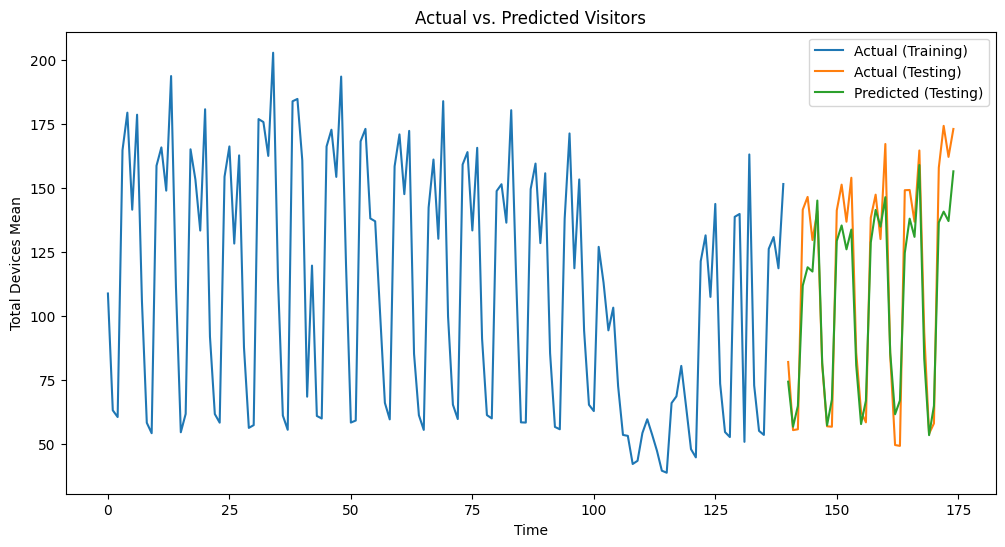

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(wifi['totaldevicesmean'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
wifi_model = Sequential()
wifi_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
wifi_model.add(LSTM(50, activation='relu'))
wifi_model.add(Dense(1))
wifi_model.compile(optimizer='adam', loss='mse')

# Train the model
history = wifi_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = wifi_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

print(X_test)

# Make predictions
predictions = wifi_model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)

# Inverse scale the actual values for plotting
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted visitor numbers
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Mean')
plt.legend()
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 373.20083098785454
Root Mean Squared Error (RMSE): 19.31840653335193
Minimum value: 49.083333333333336
Maximum value: 174.29166666666666
Range: 125.20833333333331
Mean Absolute Percentage Error (MAPE): 12.731313479857304%
R-squared (Coefficient of Determination): 0.8059786503541784


LSTM Model Test Loss: 0.0020602017175406218
[[[0.6875  ]
  [0.71875 ]
  [0.703125]
  [0.703125]
  [0.734375]
  [0.796875]
  [0.75    ]]

 [[0.71875 ]
  [0.703125]
  [0.703125]
  [0.734375]
  [0.796875]
  [0.75    ]
  [0.8125  ]]

 [[0.703125]
  [0.703125]
  [0.734375]
  [0.796875]
  [0.75    ]
  [0.8125  ]
  [0.765625]]

 [[0.703125]
  [0.734375]
  [0.796875]
  [0.75    ]
  [0.8125  ]
  [0.765625]
  [0.765625]]

 [[0.734375]
  [0.796875]
  [0.75    ]
  [0.8125  ]
  [0.765625]
  [0.765625]
  [0.765625]]

 [[0.796875]
  [0.75    ]
  [0.8125  ]
  [0.765625]
  [0.765625]
  [0.765625]
  [0.78125 ]]

 [[0.75    ]
  [0.8125  ]
  [0.765625]
  [0.765625]
  [0.765625]
  [0.78125 ]
  [0.6875  ]]

 [[0.8125  ]
  [0.765625]
  [0.765625]
  [0.765625]
  [0.78125 ]
  [0.6875  ]
  [0.8125  ]]

 [[0.765625]
  [0.765625]
  [0.765625]
  [0.78125 ]
  [0.6875  ]
  [0.8125  ]
  [0.78125 ]]

 [[0.765625]
  [0.765625]
  [0.78125 ]
  [0.6875  ]
  [0.8125  ]
  [0.78125 ]
  [0.75    ]]

 [[0.765625]
  [0.78125 ]


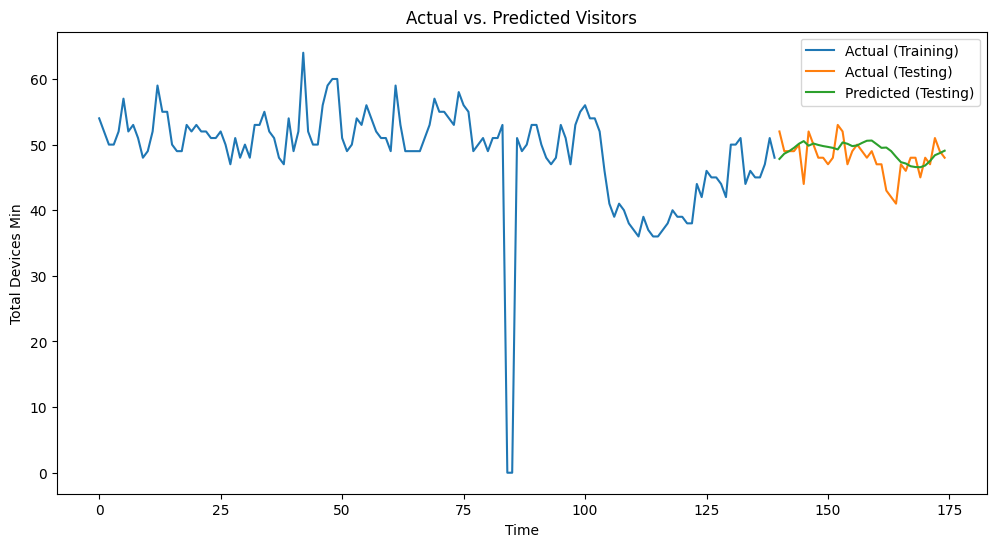

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(wifi['totaldevicesmin'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

print(X_test)

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)

# Inverse scale the actual values for plotting
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted visitor numbers
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Min')
plt.legend()
plt.show()

In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 7.204786845321568
Root Mean Squared Error (RMSE): 2.684173400755169
Minimum value: 41.0
Maximum value: 53.0
Range: 12.0
Mean Absolute Percentage Error (MAPE): 4.33945475751035%
R-squared (Coefficient of Determination): -0.025071299131117275


[[[195]
  [ 72]
  [ 72]
  ...
  [377]
  [298]
  [442]]

 [[ 72]
  [ 72]
  [387]
  ...
  [298]
  [442]
  [227]]

 [[ 72]
  [387]
  [377]
  ...
  [442]
  [227]
  [ 83]]

 ...

 [[366]
  [351]
  [429]
  ...
  [ 72]
  [ 74]
  [385]]

 [[351]
  [429]
  [196]
  ...
  [ 74]
  [385]
  [443]]

 [[429]
  [196]
  [ 72]
  ...
  [385]
  [443]
  [390]]]
LSTM Model Test Loss: 1281.3607177734375
[[[109]
  [ 65]
  [ 72]
  [289]
  [302]
  [261]
  [351]]

 [[ 65]
  [ 72]
  [289]
  [302]
  [261]
  [351]
  [136]]

 [[ 72]
  [289]
  [302]
  [261]
  [351]
  [136]
  [ 65]]

 [[289]
  [302]
  [261]
  [351]
  [136]
  [ 65]
  [ 65]]

 [[302]
  [261]
  [351]
  [136]
  [ 65]
  [ 65]
  [336]]

 [[261]
  [351]
  [136]
  [ 65]
  [ 65]
  [336]
  [351]]

 [[351]
  [136]
  [ 65]
  [ 65]
  [336]
  [351]
  [292]]

 [[136]
  [ 65]
  [ 65]
  [336]
  [351]
  [292]
  [301]]

 [[ 65]
  [ 65]
  [336]
  [351]
  [292]
  [301]
  [136]]

 [[ 65]
  [336]
  [351]
  [292]
  [301]
  [136]
  [ 73]]

 [[336]
  [351]
  [292]
  [301]
  [13

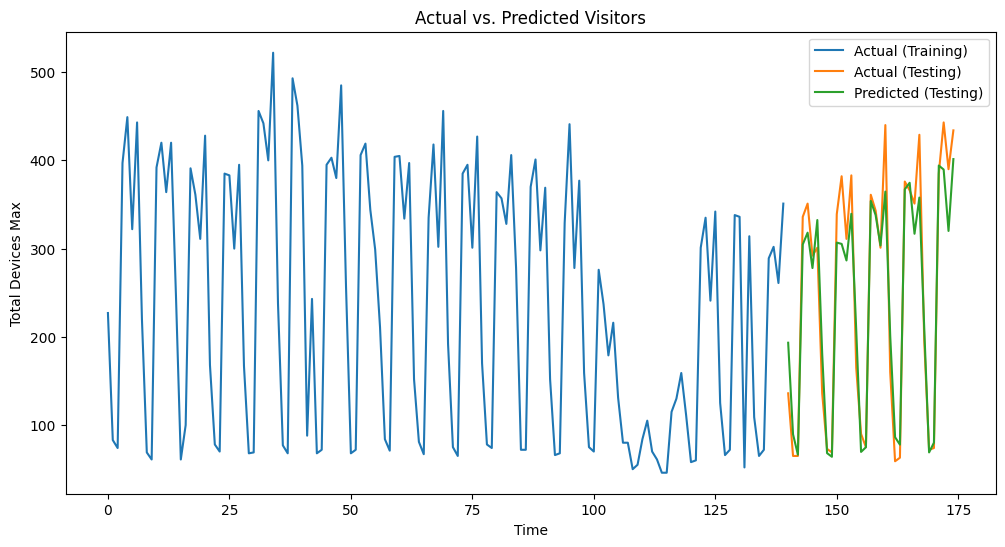

In [30]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

print(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

print(X_test)

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 1809.8141013873492
Root Mean Squared Error (RMSE): 42.54190994052041
Minimum value: 59
Maximum value: 443
Range: 384
Mean Absolute Percentage Error (MAPE): 14.089506613865721%
R-squared (Coefficient of Determination): 0.9062813808718753


In [28]:
# Save WiFi Model

model.save("wifidata_model.h5")